In [32]:
from typing import List, Dict
import math
import os
import pickle

import casadi as cas
import numpy as np
from scipy import signal
from dataclasses import dataclass
import matplotlib.pyplot as plt

from IOData.IOData import IOData, InputRule
from System.ErrorKinematicAcceLATI import LinearizedErrorKinematicAcceModel, LinearizedErrorKinematicAcceModelParams, KinematicAcceModelParams
from tools.simualtion_results import Results, PlotStyle

In [33]:
results = Results(0.01)
results.trajecory_style
test_dict = {}
test_dict[tuple([1,1])] = 2
test_dict[(1,1)]

2

In [34]:
# parameters for kinematic model
l_r = 0.052
l_f = 0.038
# sampling time, control and output constraints
Ts = 1/100
a_min, a_max = -3, 6
delta_max = 0.35*math.pi
# y_max = 0.25
# x_max = 1
t = 0.5/2 # half track width
v_min, v_max = -3, 5
mu_min, mu_max = -0.5*math.pi, 0.5*math.pi

# track parameters
cur = 1/0.3
state_s0 = [0,0,0] # [x_p0, y_p0, Psi_0]
# steady state speed
v_0 = 1.5

# noise level
n_e_lat_max = 0.002
n_mu_max = 0.01
n_v_max = 0.005
n_l_max = 0.002

# maximum control inputs for collecting dataset
a_d_max = 4
delta_d_max = 2e-2
t_data = 10
length = int(t_data/Ts) # length of dataset
# intial state of system, set near steady state to eusure quality of data!
exact_state_0 = np.array([0,0,0,0])

# maximum control inputs for simulation
a_sim = 10
delta_sim = 0.12*math.pi

o=3
A_y = np.matrix(np.vstack((
    np.hstack(( np.eye(2),np.zeros((2,o-2)) )),
    np.hstack(( -np.eye(2),np.zeros((2,o-2)) ))
)))
# A_y = np.matrix(np.vstack((
#     np.hstack(( np.eye(1),np.zeros((1,o-1)) )),
#     np.hstack(( -np.eye(1),np.zeros((1,o-1)) ))
# )))
A_n = np.matrix(np.vstack(( np.eye(o), -np.eye(o) )))

# intialize a system to get zero_state and zero_input
sys = LinearizedErrorKinematicAcceModel(
    LinearizedErrorKinematicAcceModelParams(
            KinematicAcceModelParams(l_r=l_r,l_f=l_f,Ts=Ts),
            cur = cur,
            state_s0= state_s0,
            v_0 = v_0),
    exact_state_0)
zero_input = sys.get_zero_input()
zero_state = sys.get_zero_state()

linearized_params = LinearizedErrorKinematicAcceModelParams(
    KinematicAcceModelParams(l_r=l_r,l_f=l_f,Ts=Ts),
    cur = cur,
    state_s0= state_s0,
    v_0 = v_0,
    A_u = np.matrix('1 0; 0 1; -1 0; 0 -1'),
    b_u = np.matrix([[a_max],[delta_max],[-a_min],[delta_max]]),
    # A_y = np.matrix('1 0 0 0; 0 1 0 0; -1 0 0 0; 0 -1 0 0'),
    A_y = A_y,
    # b_y = np.matrix([[t],[t]]),
    b_y = np.matrix([[t],[mu_max],[t],[-mu_min]]),
    A_n = A_n,
    # b_n = np.matrix([[n_x_max],[n_y_max],[n_psi_max],[n_v_max],[n_x_max],[n_y_max],[n_psi_max],[n_v_max]]),
    # b_n = np.matrix([[n_x_max],[n_y_max],[n_psi_max],[n_x_max],[n_y_max],[n_psi_max]]),
    b_n = np.matrix([[n_e_lat_max],[n_mu_max],[n_v_max],[n_e_lat_max],[n_mu_max],[n_v_max]]),
    # b_n = np.matrix([[n_e_lat_max],[n_mu_max],[n_e_lat_max],[n_mu_max]]),
    # b_n = np.matrix([[n_e_lat_max],[n_e_lat_max]]),
)

sys = LinearizedErrorKinematicAcceModel(linearized_params, np.array([0,0,zero_state[1],zero_state[2]]))
sys_for_l = LinearizedErrorKinematicAcceModel(linearized_params, np.array([0,0,0,v_0]))
# sys = LinearizedErrorKinematicAcceModel(linearized_params, np.array([0,0,0,v_0]))

# controlling parameters
L=int(0.5/Ts)
lag=9
steps=3
# simulation time and steps
T = 3
N = int(T/Ts)
N_block = int(N/steps)
J = int(N_block/5) # Save predicted trajectory every J blocks

# use saved data or not
use_saved_data = True

print(sys.l)
print(sys._B)
print(sys._C)
print(sys._b_u)
print(sys._b_y)
print(sys._b_n)
print(sys.state)
print(sys.kinematic_model.state)
print(zero_input)
print(zero_state)

4
[[-1.72051496e-21  1.04870716e-02]
 [-6.65224157e-20  1.73147358e-01]
 [ 1.00000000e-02  0.00000000e+00]
 [ 5.00000000e-05  2.51354628e-04]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
[[6.        ]
 [1.09955743]
 [3.        ]
 [1.09955743]]
[[0.25      ]
 [1.57079633]
 [0.25      ]
 [1.57079633]]
[[0.002]
 [0.01 ]
 [0.005]
 [0.002]
 [0.01 ]
 [0.005]]
[ 0.         -0.17421323  1.5         0.        ]
[ 0.          0.         -0.17421323  1.5       ]
[0.         0.29568153]
[ 0.         -0.17421323  1.5         0.        ]


In [35]:
from IOData.IODataWith_l import IODataWith_l
if use_saved_data:
    with open(os.path.join(os.getcwd(), 'datasets', f'io_datas_{t_data}_{Ts}.pkl'), 'rb') as read_file:
        io_datas: Dict[float, IODataWith_l] = pickle.load(read_file)
    io_data = io_datas[cur]
    io_data.update_depth(lag+L)
    io_data.update_l_estimation_matrix(L, lag)
    length = io_data.length
else:
    io_data = IODataWith_l(L+lag, sys=sys, input_rule=InputRule.RANDOM_2_WITH_MEAN, mean_input=np.matrix(zero_input).transpose(), length=length,
                    A_u_d=np.matrix('1 0; 0 1; -1 0; 0 -1'), b_u_d=np.matrix([[a_d_max],[delta_d_max],[a_d_max],[delta_d_max]]),
                    n_l = n_l_max, lag = lag, L = L, N_l = int(length/2), K_l = 5)

# remember to rest the system state after initializing io_data
# sys.set_kinematic_model_state(exact_state_0)
sys.set_error_state(zero_state)
print(length)

1000


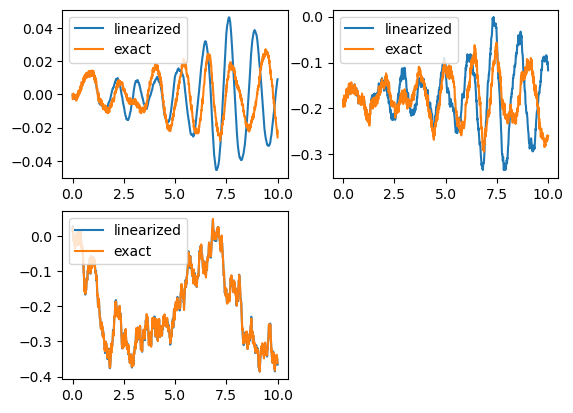

In [36]:

plt.subplot(221)
plt.plot(np.linspace(0,t_data,length),[y[0,0] for y in io_data._output_data],label='linearized')
plt.plot(np.linspace(0,t_data,length),[y[0,0]+n[0,0] for y,n in zip(io_data._output_data,io_data._noise_data)],label='exact')
plt.legend()
plt.subplot(222)
plt.plot(np.linspace(0,t_data,length),[y[1,0] for y in io_data._output_data],label='linearized')
plt.plot(np.linspace(0,t_data,length),[y[1,0]+n[1,0] for y,n in zip(io_data._output_data,io_data._noise_data)],label='exact')
plt.legend()
plt.subplot(223)
plt.plot(np.linspace(0,t_data,length),[y[2,0] for y in io_data._output_data],label='linearized')
plt.plot(np.linspace(0,t_data,length),[y[2,0]+n[2,0] for y,n in zip(io_data._output_data,io_data._noise_data)],label='exact')
plt.legend()

In [37]:
# from SafetyFilters.NominalFewSlack_Tightened_LTAI_mu import *
from SafetyFilters.NominalFewSlack_Tightened_LTAISSGiven import *
from SafetyFilters.NominalSlackDDSF_Tightened import *

In [38]:
filter_params = NominalFewSlackTightenedSFParams(
    L=L, lag=lag, R=np.matrix('1 0; 0 100'), lam_sig=50000, epsilon=1e-3,
    c=[
        [0.3*t, 0.1*t, 0.05*t, 0.01*t],
        [0.3*mu_max, 0.1*mu_max, 0.05*mu_max, 0.01*mu_max],
        # [0.5*mu_max, 0.2*mu_max, 0.1*mu_max, 0.01*mu_max],
    ],
    sf_params=SFParams(steps=steps, verbose=False, solver=cp.MOSEK,
                       solver_args={'mosek_params':{
                           'MSK_DPAR_INTPNT_CO_TOL_PFEAS':1e-5,
                           'MSK_DPAR_INTPNT_CO_TOL_DFEAS':1e-5,
                           'MSK_DPAR_INTPNT_CO_TOL_REL_GAP':1e-3,
                           'MSK_DPAR_INTPNT_CO_TOL_INFEAS':1e-5,
                           'MSK_IPAR_INTPNT_MAX_ITERATIONS': 30000}})
)

filter = NominalFewSlackTightenedDDSafetyFilter(sys, io_data, filter_params)
print(zero_input)
print(zero_state)
# print(100*(zero_input[1]-filter._u_s[1])/zero_input[1])
# print(100*(zero_state[1]-filter._y_s[1])/zero_state[1])

Fited steady state input: [0.         0.29530326]
Fited steady state output: [ 0.         -0.17135017  0.        ]
[0.         0.29568153]
[ 0.         -0.17421323  1.5         0.        ]


In [39]:
use_more_slack = True
if use_more_slack:
    epsilon = max(n_e_lat_max, n_mu_max)
    filter_params = NominalSlackTightenedParams(
        L=L, lag=lag, R=np.matrix('1 0; 0 100'), lam_alph=90/epsilon, lam_sig=100, epsilon=epsilon,
        c=[
            [0.35*t, 0.1*t, 0.1*t, 0.05*t],
            [0.4*mu_max, 0.1*mu_max, 0.1*mu_max, 0.05*mu_max],
            # [0.5*mu_max, 0.2*mu_max, 0.1*mu_max, 0.01*mu_max],
        ],
        sf_params=SFParams(steps=steps, verbose=True, solver=cp.MOSEK, solver_args={'mosek_params':{
            'MSK_DPAR_INTPNT_CO_TOL_PFEAS':1e-4,
            'MSK_DPAR_INTPNT_CO_TOL_DFEAS':1e-3,
            'MSK_DPAR_INTPNT_CO_TOL_INFEAS':1e-6,
            'MSK_DPAR_INTPNT_CO_TOL_REL_GAP':1e-4}})
    )

    filter = NominalSlackTightenedSafetyFilter(sys, io_data, filter_params)
print(type(filter))
# remember to rest the system state after initializing io_data
# sys.set_kinematic_model_state(exact_state_0)
sys.set_error_state(np.array([0,0,0,0]))
print(sys._x)
print(sys.state)
print(sys.kinematic_model.state)

<class 'SafetyFilters.NominalSlackDDSF_Tightened.NominalSlackTightenedSafetyFilter'>
[[ 0.        ]
 [ 0.17421323]
 [-1.5       ]
 [ 0.        ]]
[0 0 0 0]
[1.8369702e-17 0.0000000e+00 0.0000000e+00 0.0000000e+00]


In [40]:
# fix random seed
np.random.seed(0)

# Trajectory with initial conditions
from copy import deepcopy
sys.set_error_state(np.array([0,0,0,0]))

# traj_u: List[np.matrix] = [np.matrix(filter._u_s).transpose() for _ in range(lag)]
traj_u: List[np.matrix] = [np.matrix([[0] for __ in range(sys.m)]) for _ in range(lag)]
u_obj_list: List[np.matrix] = []
# traj_y: List[np.matrix] = [np.matrix(filter._y_s).transpose() for _ in range(lag)]
traj_y: List[np.matrix] = [np.matrix([[0], [0], [-v_0]]) for _ in range(lag)]
# traj_z: List[np.matrix] = [] # list of system states, just for visualization
traj_noise: List[np.matrix] = [np.matrix([[0] for __ in range(sys.p)]) for _ in range(lag)]
traj_l: List[np.matrix] = [np.matrix(n_l_max*(2*np.random.rand()-1)) for _ in range(lag)]

# Global trajectory of the vehicle, for visulization
# global_linearized: List[np.matrix] = []
global_exact: List[np.ndarray] = []
error_from_global: List[np.ndarray] = []
# global_steady_state: List[np.matrix] = []
# global_constraint_upper: List[np.matrix] = []
# global_constraint_lower: List[np.matrix] = []
results = Results(Ts)

status_list: List = []
opt_val: List[float] = []
sigma_norm: List[float] = []

predicted_trajs: Dict[int, np.ndarray] = {}
predicted_l_trajs: Dict[int, np.ndarray] = {}
real_trajs_under_u: Dict[int, List[np.ndarray]] = {}


for i in range(N_block):
    u_obj = np.matrix(np.ndarray((0,1)))
    for j in range(steps):
        k = i*steps + j
        u_obj_k = np.matrix([[a_sim*math.sin(k*Ts*math.pi)],[delta_sim*math.sin(k*3*Ts*math.pi)]])
        # u_obj_k = np.matrix([[a_sim],[delta_sim*math.sin(k*3*Ts*math.pi)]])
        # if k <= K:
        #     u_obj_k = np.matrix(10)
        # else:
        #     u_obj_k = np.matrix(-10)
        u_obj_list.append(u_obj_k)
        u_obj = np.vstack( (u_obj, u_obj_k) )
    
    k = i*steps
    xi_i = np.vstack(tuple( traj_u[k:k+lag] + [traj_y[_] + traj_noise[_] for _ in range(k,k+lag)] ))
    u_i, status_i, opt_i = filter.filter(xi_i, u_obj)
    sigma_norm.append(npl.norm(filter._sigma.value,np.inf))

    if i%J == 0:
        if use_more_slack:
            predicted_trajs[i*steps] = filter._y.value[lag*filter._p:]
            proposed_us = filter._u.value[lag*filter._m:]
            predicted_traj = np.split(filter._y.value[lag*filter._p:], L)
            for y in predicted_traj:
                y[1] = y[1] * 180 / np.pi
                y[2] = y[2] + v_0
            results.add_predicted_error_slice(i*steps*Ts, predicted_traj)
        else:
            predicted_trajs[i*steps] = filter._y.value
            proposed_us = filter._u.value
            predicted_traj = np.split(filter._y.value, L)
            for y in predicted_traj:
                y[1] = y[1] * 180 / np.pi
                y[2] = y[2] + v_0
            results.add_predicted_error_slice(i*steps*Ts, predicted_traj)
        # reset linearized system state, for visulizing purpose
        # sys._x = np.matrix(sys.state-sys._x_r_lin).transpose()

        l_obs = deepcopy(np.vstack(tuple(traj_l[k:k+lag])))
        l_obs = l_obs - l_obs[-1,0] # translate observation to zero at previous step
        # get the predicted l trajectories
        l_predicted = filter._io_data.get_l_estimation(
            xi_i[:lag*filter._m],
            np.matrix(proposed_us).transpose(),
            l_obs,
        )
        predicted_l_trajs[i*steps] = l_predicted - l_predicted[0] # translate to zero at first step
        # get the real l trajectories
        real_states_under_u: List[np.ndarray] = []
        # reset l_0 for both systems, to have a better visulization
        sys.set_l_0(sys.state[3]+sys._l_0)
        sys_for_l.set_error_state(sys.state)
        for j in range(L):
            real_states_under_u.append(sys_for_l.state)
            sys_for_l.step(np.matrix(proposed_us).transpose()[j*sys_for_l.m:(j+1)*sys_for_l.m])
        real_trajs_under_u[i*steps] = real_states_under_u


    for j in range(steps):
        global_state = sys.kinematic_model.state
        error_global = sys.state
        error_global_deg = deepcopy(error_global)
        error_global_deg[1] = error_global_deg[1] * 180 / np.pi
        traj_l.append(np.matrix(sys.state[3]+n_l_max*(2*np.random.rand()-1)))

        y_t, n_t = sys.step(u_i[j*sys.m:(j+1)*sys.m])

        results.add_point(u_obj[j*sys.m:(j+1)*sys.m], u_i[j*sys.m:(j+1)*sys.m],
                          global_state, np.zeros(global_state.shape),
                          error_global_deg, np.zeros(error_global.shape),)

        traj_u.append(u_i[j*sys.m:(j+1)*sys.m])
        traj_y.append(y_t)
        traj_noise.append(n_t)
        # traj_z.append( U @
            # (np.transpose(np.matrix(sys.kinematic_model._state)) - z_s)
            # )

        # z_global_linearized = z_s[:o] + U_inv@y_t
        # z_global_exact = z_s[:o] + U_inv@(y_t+n_t)
        # global_linearized.append(z_global_linearized)
        global_exact.append(global_state)
        error_from_global.append(error_global)
        # global_steady_state.append(z_s[:o])

        # # for drawing the constraints
        # global_constraint_upper.append(z_s[:2] + U_inv[:2,:2]@np.matrix([[0],[y_max]]))
        # global_constraint_lower.append(z_s[:2] + U_inv[:2,:2]@np.matrix([[0],[-y_max]]))



    status_list.append(status_i)
    opt_val.append(opt_i)

# delete initial input and output, for drawing purposes
for _ in range(lag):
    traj_y.pop(0)
    traj_u.pop(0)
    traj_noise.pop(0)
    traj_l.pop(0)
print(traj_noise[-1])

# # Save output to file
# with open('output.txt', 'w') as f:
#     f.write(cap.stdout)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Aug 04 02:20:45 PM: Your problem has 1414 variables, 99 constraints, and 51 parameters.
(CVXPY) Aug 04 02:20:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 04 02:20:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 04 02:20:45 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Aug 04 02:20:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Aug 04 02:20:45 PM: Applying reduction Dcp2Cone
(CVXPY) Aug 04 02:20:45 PM: Applying reduction CvxAttr2Constr
(C

Exception: Problem not optimal: status is infeasible

<Axes: title={'center': 'Vehicle trajectory'}, xlabel='x [m]', ylabel='y [m]'>

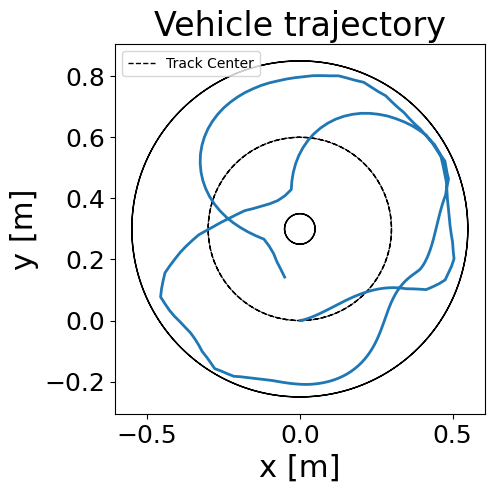

In [ ]:
import matplotlib.pyplot as plt
from tools.simple_track_generator import trackGenerator
gen = trackGenerator(density=300, track_width=2*t)
if cur == 0:
    gen.addLine(x0=state_s0[0], y0=state_s0[1],
                x1=state_s0[0]+np.cos(state_s0[2]), y1=state_s0[1]+np.sin(state_s0[2]),
                dist=5)
elif cur > 0:
    gen.left_turn(state_s0, 1/cur, 2*np.pi)
else:
    gen.right_turn(state_s0, -1/cur, 2*np.pi)
gen.populatePointsAndArcLength()
fig, ax = plt.subplots()
results.plot_vehicle_trajectory(ax=ax, gen=gen)

<Axes: xlabel='time [s]', ylabel='$v$ [m/s]'>

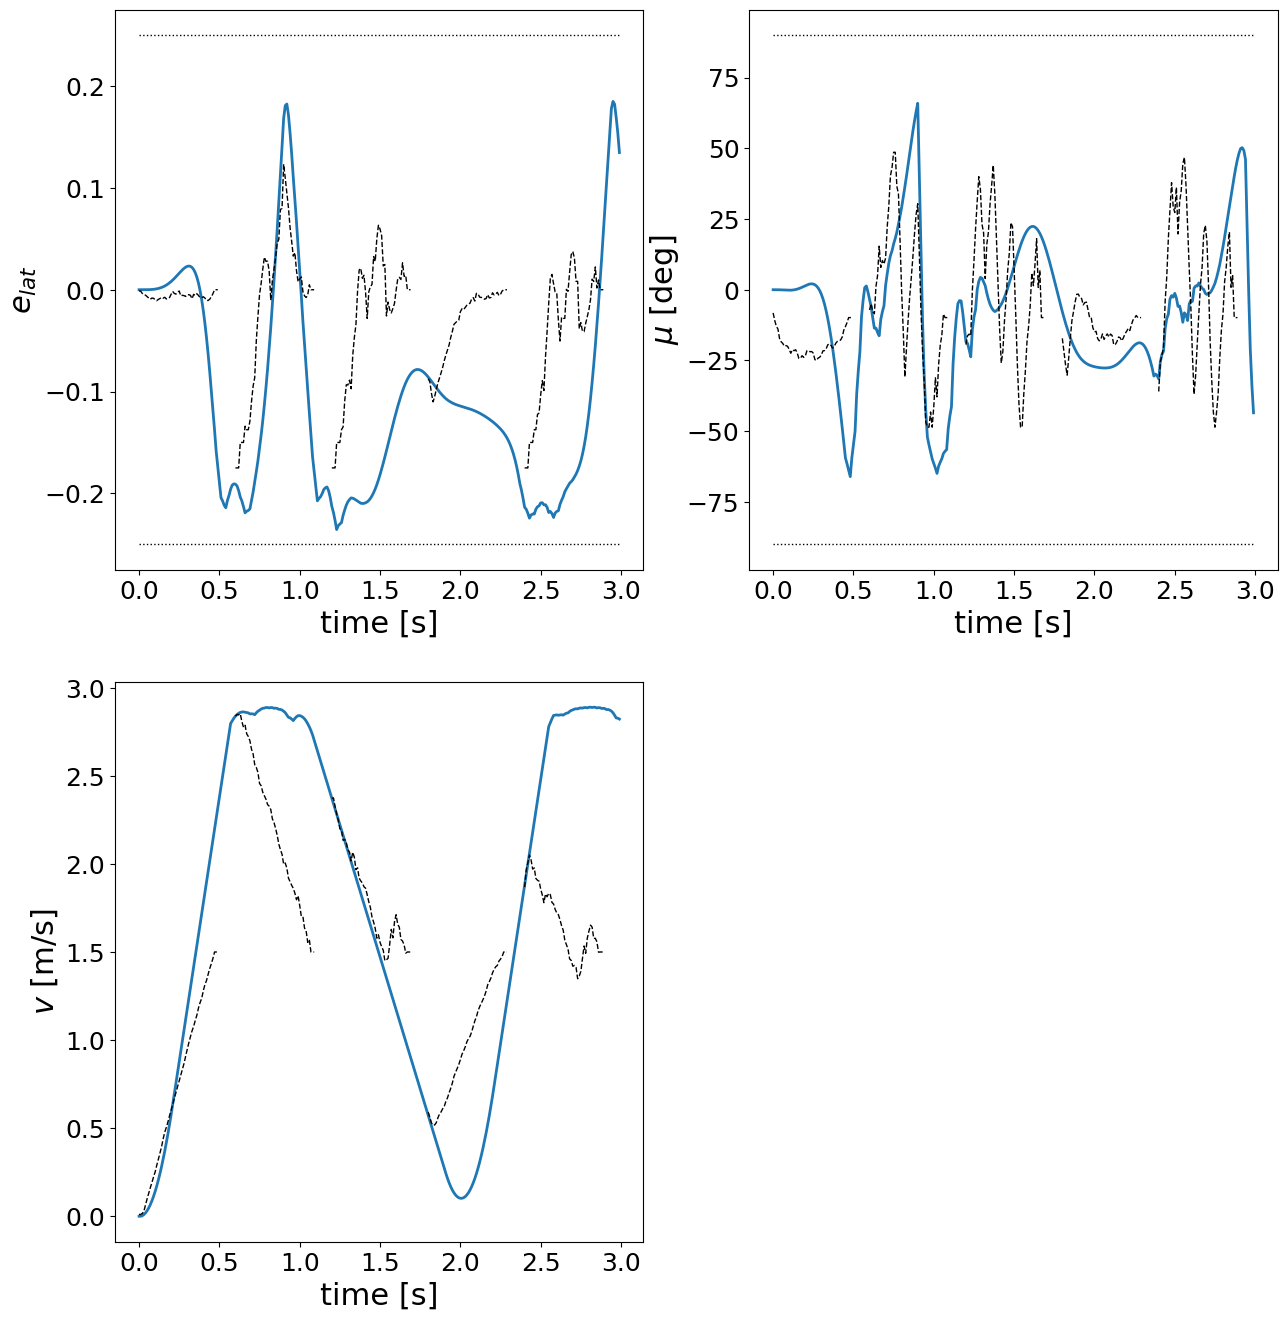

In [ ]:
# plot given input and actual input
plt.figure(figsize=(15,16))
#velocity input
ax = plt.subplot(221)
results.plot_error_trajectory(0, ax, constraint=(-t, t))
results.plot_predicted_error_slices(0, ax)
ax = plt.subplot(222)
results.plot_error_trajectory(1, ax, constraint=(mu_min*180/np.pi, mu_max*180/np.pi))
results.plot_predicted_error_slices(1, ax)
ax = plt.subplot(223)
results.plot_error_trajectory(2, ax)
results.plot_predicted_error_slices(2, ax)

In [ ]:
print(max(sigma_norm))
print(min(sigma_norm))

0.02973120275439725
1.0824614982141156e-08


<Axes: xlabel='time [s]', ylabel='$\\delta$ [rad]'>

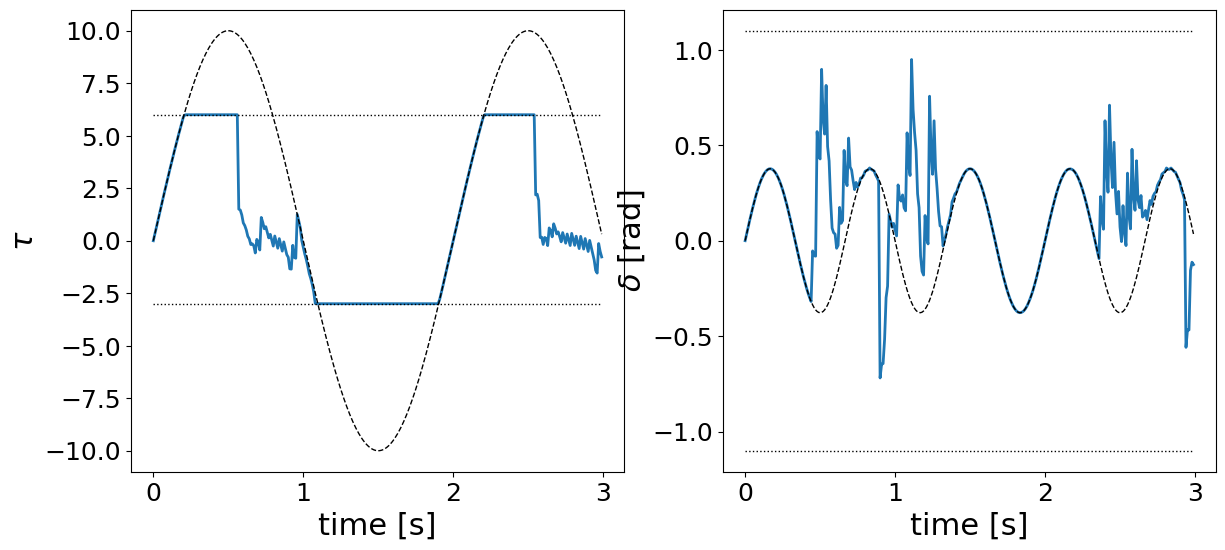

In [ ]:
plt.figure(figsize=(14,6))
ax = plt.subplot(121)
results.plot_input_applied(0, ax, constraint=(a_min, a_max))
results.plot_input_obj(0, ax)
ax = plt.subplot(122)
results.plot_input_applied(1, ax, constraint=(-delta_max, delta_max))
results.plot_input_obj(1, ax)

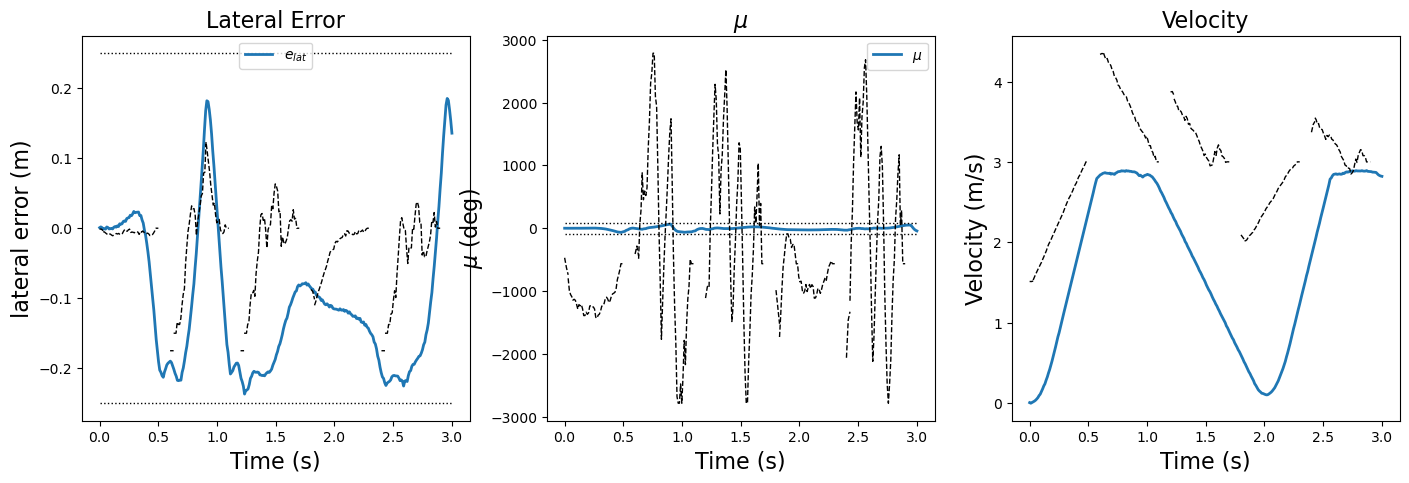

In [ ]:
# plot error trajectory
import math
plt.figure(figsize=(17,5))
#e_lat
plt.subplot(131)
# p = plt.plot(np.linspace(0,T,len(traj_y)), [z[0,0] for z in traj_y], label='linearized e_lat')
# color_lin = p[0].get_color()
p = plt.plot(np.linspace(0,T,len(traj_y)), [z[0,0]+n[0,0] for z,n in zip(traj_y,traj_noise)], label='$e_{lat}$', color='tab:blue', linewidth=2, linestyle='-')
color_exact = p[0].get_color()
# p = plt.plot(np.linspace(0,T,len(traj_y)), [z[0] for z in error_from_global], label='e_lat from global traj')
# color_global = p[0].get_color()
plt.xlabel(r'Time (s)', fontsize=16)
plt.ylabel(r'lateral error (m)', fontsize=16)
plt.title('Lateral Error', fontsize=16)

# plot predicted trajectory
for i, y_predicted in predicted_trajs.items():
#     p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), y_predicted[:3*lag:3], ":")
    p = plt.plot(np.linspace(i*Ts, (i+steps)*Ts, steps), y_predicted[:o*(steps):o], "--", color='black', linewidth=1)
    # color = p[0].get_color()
    plt.plot(np.linspace((i+steps)*Ts, (i+L)*Ts, L-steps), y_predicted[o*(steps)::o], "--", color='black', linewidth=1)
    # plot the "real trajectory if the predicte"

# plot constraint
p = plt.plot([0,T],[t, t], color='black', linestyle=':', linewidth=1)
plt.plot([0,T],[-t, -t], color='black', linestyle=':', linewidth=1)
plt.legend()

#mu
plt.subplot(132)
# plt.plot(np.linspace(0,T,len(traj_y)), [z[1,0]*180/math.pi for z in traj_y], label='linearized \mu', color=color_lin)
plt.plot(np.linspace(0,T,len(traj_y)), [(z[1,0]+n[1,0])*180/math.pi  for z,n in zip(traj_y,traj_noise)], label='$\mu$', color='tab:blue', linewidth=2, linestyle='-')
plt.xlabel(r'Time (s)', fontsize=16)
plt.ylabel(r'$\mu$ (deg)', fontsize=16)
plt.title('$\mu$', fontsize=16)

#plot predicted trajectory
for i, y_predicted in predicted_trajs.items():
    # p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), [z[1,0] for z in y_predicted[:lag]], ":")
#     p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), y_predicted[1:3*lag+1:3], ":")
    p = plt.plot(np.linspace(i*Ts, (i+steps)*Ts, steps), y_predicted[1:o*(steps)+1:o]*180/math.pi, '--', color='black', linewidth=1)
    color = p[0].get_color()
    plt.plot(np.linspace((i+steps)*Ts, (i+L)*Ts, L-steps), y_predicted[o*(steps)+1::o]*180/math.pi, '--', color='black', linewidth=1)

# plot constraint
mu_max_deg = mu_max*180/math.pi
mu_min_deg = mu_min*180/math.pi
p = plt.plot([0,T],[mu_max_deg, mu_max_deg ], color='black', linestyle=':', linewidth=1)
color = p[0].get_color()
plt.plot([0,T],[mu_min_deg, mu_min_deg], color='black', linestyle=':', linewidth=1)
plt.legend()

if True:
    #v
    plt.subplot(133)
    # p = plt.plot(np.linspace(0,T,len(traj_y)), [z[2,0] for z in traj_y], label='linearized v_error',color=color_lin)
    p = plt.plot(np.linspace(0,T,len(traj_y)), [z[2,0]+n[2,0]+v_0 for z,n in zip(traj_y,traj_noise)], label='$v$', color='tab:blue', linewidth=2, linestyle='-')
    plt.xlabel(r'Time (s)', fontsize=16)
    plt.ylabel(r'Velocity (m/s)', fontsize=16)
    plt.title('Velocity', fontsize=16)

    # plot predicted trajectory
    for i, y_predicted in predicted_trajs.items():
    #     p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), y_predicted[:3*lag:3], ":")
        p = plt.plot(np.linspace(i*Ts, (i+steps)*Ts, steps), y_predicted[2:2+o*(steps):o]+v_0, '--', color='black', linewidth=1)
        color = p[0].get_color()
        plt.plot(np.linspace((i+steps)*Ts, (i+L)*Ts, L-steps), y_predicted[2+o*(steps)::o]+v_0, "--", color='black', linewidth=1)
if False:
    #l
    plt.subplot(224)

    p = plt.plot(np.linspace(0,T,len(traj_l)), [z[0,0] for z in traj_l], label='trajectory of l',color=color_exact)
    #plot predicted trajectory
    for i, l_traj in predicted_l_trajs.items():
        # p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), [z[1,0] for z in y_predicted[:lag]], ":")
    #     p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), y_predicted[1:3*lag+1:3], ":")
        p = plt.plot(np.linspace(i*Ts, (i+steps)*Ts, steps), l_traj[:steps], color='black', linestyle=':', linewidth=1)
        color = p[0].get_color()
        plt.plot(np.linspace((i+steps)*Ts, (i+L)*Ts, L-steps), l_traj[steps:], color='black', linestyle=':', linewidth=1)
    # #plot real trajectory
    # for i, error_state_traj in real_trajs_under_u.items():
    #     p = plt.plot(np.linspace(i*Ts, (i+L)*Ts, L), [error_state[3] for error_state in error_state_traj], ':')

    # plot constraint
    plt.xlabel(r'time', fontsize=16)
    plt.ylabel(r'Comparison of real l and predicted l', fontsize=16)
    plt.title('l', fontsize=16)
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/var/folders/sy/w5n70p7551x0x02tx8n0zk_r0000gn/T/ipykernel_43643/1658408804.py:54: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0,T],[mu_min_deg, mu_min_deg],'--', **constraint_style)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


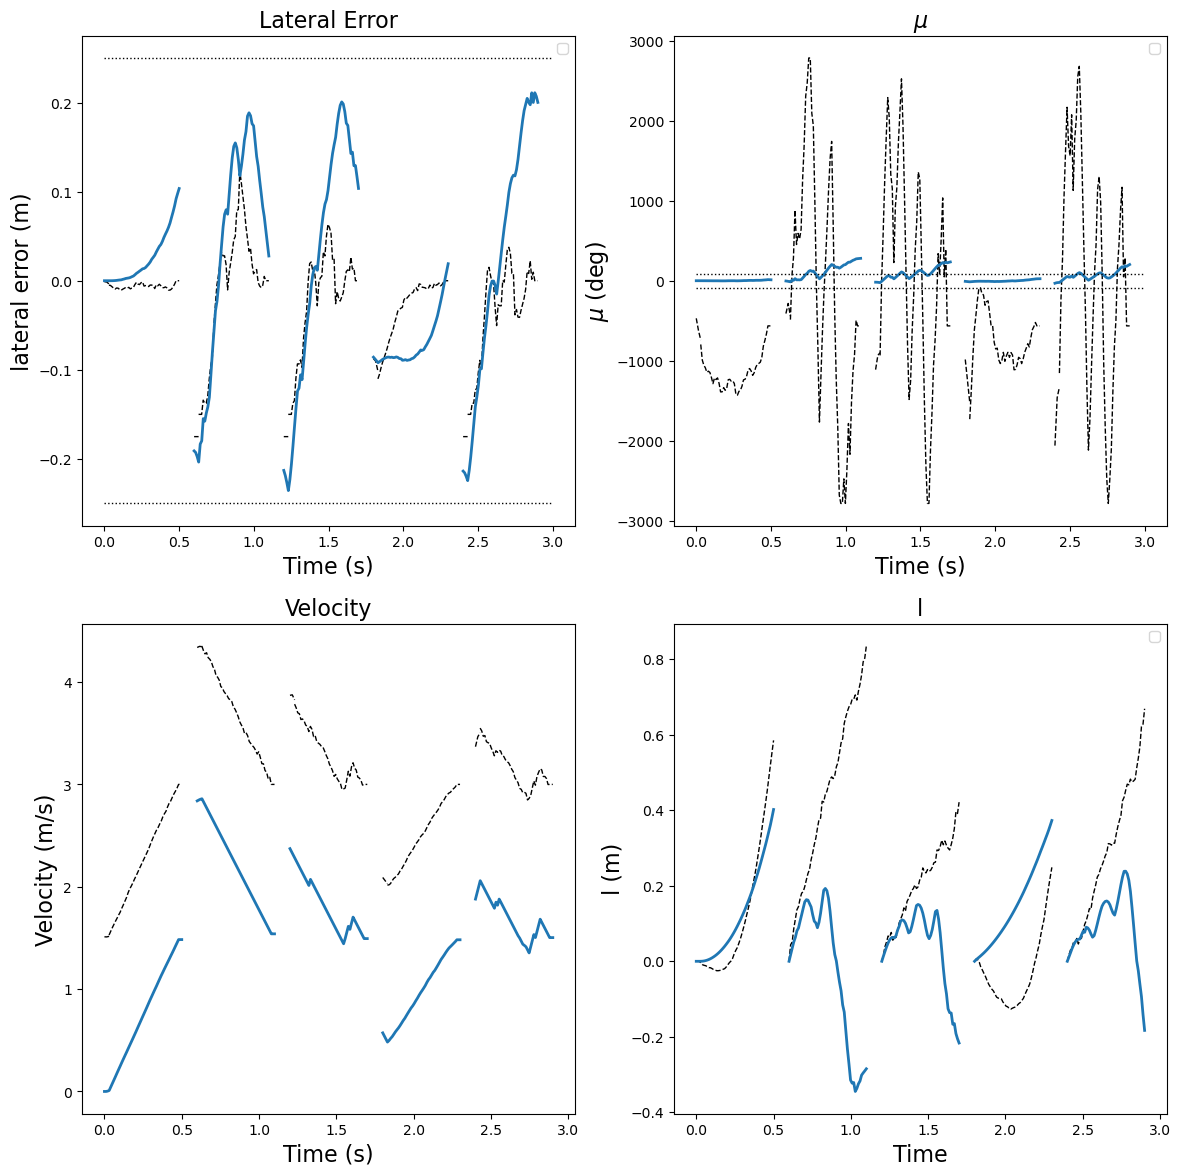

In [ ]:
# plot comparison between predicted and "true trajectory if the proposed inputs are applied"
traj_style = dict(color='tab:blue', linestyle='-', linewidth=2)
predicted_style = dict(color='black', linestyle='--', linewidth=1)
constraint_style = dict(color='black', linestyle=':', linewidth=1)
import math
plt.figure(figsize=(14,14))
#e_lat
plt.subplot(221)
plt.xlabel(r'Time (s)', fontsize=16)
plt.ylabel(r'lateral error (m)', fontsize=16)
plt.title('Lateral Error', fontsize=16)

# plot predicted trajectory
for i, y_predicted in predicted_trajs.items():
#     p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), y_predicted[:3*lag:3], ":")
    p = plt.plot(np.linspace(i*Ts, (i+steps)*Ts, steps), y_predicted[:o*(steps):o], **predicted_style)
    color = p[0].get_color()
    plt.plot(np.linspace((i+steps)*Ts, (i+L)*Ts, L-steps), y_predicted[o*(steps)::o], **predicted_style)
    # plot the "real trajectory if the proposed inputs are applied"
    real_traj = real_trajs_under_u[i]
    plt.plot(np.linspace(i*Ts, (i+L)*Ts, L), [error_state[0] for error_state in real_traj], **traj_style)

# plot constraint
p = plt.plot([0,T],[t, t], **constraint_style)
# color = p[0].get_color()
plt.plot([0,T],[-t, -t], **constraint_style)

# plot annotations

plt.legend()

#mu
plt.subplot(222)
plt.xlabel(r'Time (s)', fontsize=16)
plt.ylabel(r'$\mu$ (deg)', fontsize=16)
plt.title('$\mu$', fontsize=16)

#plot predicted trajectory
for i, y_predicted in predicted_trajs.items():
    # p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), [z[1,0] for z in y_predicted[:lag]], ":")
#     p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), y_predicted[1:3*lag+1:3], ":")
    p = plt.plot(np.linspace(i*Ts, (i+steps)*Ts, steps), y_predicted[1:o*(steps)+1:o]*180/math.pi, **predicted_style)
    color = p[0].get_color()
    plt.plot(np.linspace((i+steps)*Ts, (i+L)*Ts, L-steps), y_predicted[o*(steps)+1::o]*180/math.pi, **predicted_style)
    # plot the "real trajectory if the proposed inputs are applied"
    real_traj = real_trajs_under_u[i]
    plt.plot(np.linspace(i*Ts, (i+L)*Ts, L), [error_state[1]*180/math.pi for error_state in real_traj], **traj_style)

# plot constraint
mu_max_deg = mu_max*180/math.pi
mu_min_deg = mu_min*180/math.pi
p = plt.plot([0,T],[mu_max_deg, mu_max_deg ], **constraint_style)
color = p[0].get_color()
plt.plot([0,T],[mu_min_deg, mu_min_deg],'--', **constraint_style)
plt.legend()

if True:
    #v
    plt.subplot(223)
    plt.xlabel(r'Time (s)', fontsize=16)
    plt.ylabel(r'Velocity (m/s)', fontsize=16)
    plt.title('Velocity', fontsize=16)

    # plot predicted trajectory
    for i, y_predicted in predicted_trajs.items():
    #     p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), y_predicted[:3*lag:3], ":")
        p = plt.plot(np.linspace(i*Ts, (i+steps)*Ts, steps), y_predicted[2:2+o*(steps):o]+v_0, **predicted_style)
        color = p[0].get_color()
        plt.plot(np.linspace((i+steps)*Ts, (i+L)*Ts, L-steps), y_predicted[2+o*(steps)::o]+v_0, **predicted_style)
        # plot the "real trajectory if the proposed inputs are applied"
        real_traj = real_trajs_under_u[i]
        plt.plot(np.linspace(i*Ts, (i+L)*Ts, L), [error_state[2] for error_state in real_traj], **traj_style)
if True:
    #l
    plt.subplot(224)

    #plot predicted trajectory
    for i, l_traj in predicted_l_trajs.items():
        # p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), [z[1,0] for z in y_predicted[:lag]], ":")
    #     p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), y_predicted[1:3*lag+1:3], ":")
        p = plt.plot(np.linspace(i*Ts, (i+L)*Ts, L), l_traj, **predicted_style)
        color = p[0].get_color()
        error_state_traj = real_trajs_under_u[i]
        p = plt.plot(np.linspace(i*Ts, (i+L)*Ts, L), [error_state[3] for error_state in error_state_traj], **traj_style)
    # #plot real trajectory
    # for i, error_state_traj in real_trajs_under_u.items():
    #     p = plt.plot(np.linspace(i*Ts, (i+L)*Ts, L), [error_state[3] for error_state in error_state_traj])

    # plot constraint
    plt.xlabel(r'Time', fontsize=16)
    plt.ylabel(r'l (m)', fontsize=16)
    plt.title('l', fontsize=16)
    plt.legend()

In [ ]:
print(min(sigma_norm))
print(max(sigma_norm))

1.0824614982141156e-08
0.02973120275439725


In [ ]:
predicted_trajs[0][3*lag:3*(lag+steps)]

array([-8.38176099e-03, -2.00290447e+01,  2.22419432e-01, -9.79498235e-03,
       -2.11175897e+01,  2.50923525e-01, -1.07522549e-02, -2.24606349e+01,
        2.88695038e-01])

In [ ]:
print(sys._p_Center)
print(sys._zero_input)
print(sys._zero_state)

[0.  0.3]
[0.         0.29568153]
[ 0.         -0.17421323  1.5         0.        ]


In [ ]:
print(max(opt_val))
print(min(opt_val))

498.1506147335983
8.59215013314223e-09


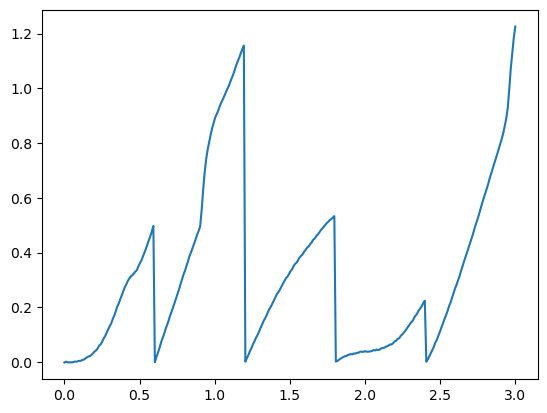

In [ ]:
plt.plot(np.linspace(0, T, len(traj_l)), [l[0,0] for l in traj_l])

In [ ]:
width_H = io_data.H_input.shape[1]
H_uy_noised: np.matrix = np.vstack( (io_data.H_input, io_data.H_output_noised_part((0, lag)), np.ones((1, width_H))) )
U, S, Vh = np.linalg.svd(H_uy_noised, full_matrices=False)
S = np.diag(np.append(S[:-1],0))
H_uy_noised_simp = U @ S @ Vh
# H_uy_noised_inv = npl.pinv(H_uy_noised_simp)
H_uy_noised_inv = npl.pinv(H_uy_noised)
A = io_data.H_output_noised_part((lag, lag+L)) @ H_uy_noised_inv

[ 0.         -0.17421323  1.5         0.        ]


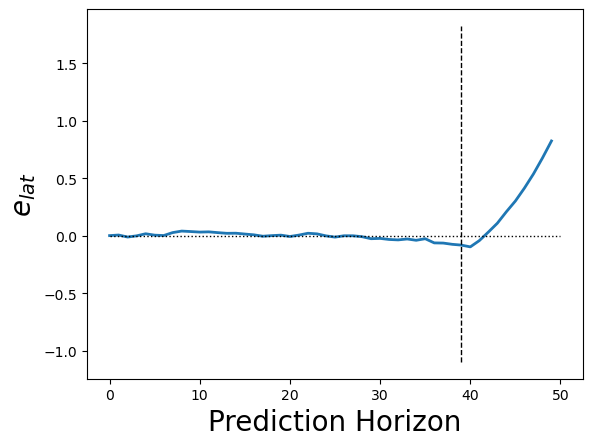

In [ ]:
print(zero_state)
l = 0
i = 0
b = np.vstack( (np.matrix(np.zeros((sys.m,1))),)*lag + (np.matrix(np.zeros((sys.m,1))),)*(L-l) + (np.matrix(5*np.ones((sys.m,1))),)*l + (np.matrix(zero_state[:3]-np.array([0,0,v_0])).transpose(),)*lag + (np.matrix(1),))
# print(b)
y_test_0 = A@b
y_test_0 = np.array(y_test_0).flatten()
# print(y_test[-sys.p*l:])
# print(max(abs(y_test[:-sys.p*l])))
l = 10
b = np.vstack( (np.matrix(np.zeros((sys.m,1))),)*lag + (np.matrix(np.zeros((sys.m,1))),)*(L-l) + (np.matrix(5*np.ones((sys.m,1))),)*l + (np.matrix(zero_state[:3]-np.array([0,0,v_0])).transpose(),)*lag + (np.matrix(1),))
y_test = np.array(A@b).flatten() - y_test_0
# y_test = np.array(A@b).flatten()
plt.plot(range(L), y_test[i::sys.p],linewidth=2, linestyle='-', color='tab:blue')
plt.plot([L-l-1,L-l-1], [min(y_test[i::sys.p])-1, max(y_test[i::sys.p])+1], linewidth=1, linestyle='--', color='black')
plt.plot([0,L],[0,0], linewidth=1, linestyle=':', color='black')
plt.xlabel('Prediction Horizon', fontsize=20)
plt.ylabel('$e_{lat}$', fontsize=20)
# plt.title('Position vs Time')
plt.show()